In [50]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])

64it [00:00, 172.79it/s]


Remove 556 out of 128484 datapoints.


In [14]:
n_obs_pass = len(actions[actions["type_name"] == "pass"])
n_obs_array = [int(n_obs_pass // 10 ** i) for i in range(3, -1, -1)]
n_obs_array

[56, 562, 5622, 56229]

In [15]:
rows = []

init = "k-means"
mask = (actions["type_name"] == "pass")
loc_data = actions.loc[mask, ["start_x", "start_y"]]
dir_data = actions.loc[mask, ["cos_angle", "sin_angle"]]
K_loc = 10
K_dir = [3 for _ in range(K_loc)]

for n_obs in n_obs_array:
    for tol in [1e-2]:
        for method in ["bregman", "approximation", "classic"]:

            # Two-layer Model
            loc_mixture = sc.MixtureModel(
                [sc.MultivariateGaussian() for _ in range(K_loc)],
                init=init,
                rng=10,
            )
            dir_mixtures = [sc.MixtureModel(
                [sc.VonMises() for _ in range(K_dir[j])],
                init=init,
                rng=j,
            )
                for j in range(K_loc)]


            model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
            start = time()
            model.fit(loc_data.iloc[:n_obs],
                      dir_data.iloc[:n_obs],
                      case=method,
                      tol=1e-2,
                      verbose=False)
            end_tl = round(time() - start, 4)
            bic_score_tl = round(model.bic_score(loc_data, dir_data), 2)

            # One-shot Model
            model = sc.OneShotScheme(n_clusters=3 * K_loc,
                                     alpha=1,
                                     beta=1,
                                     init=init)

            start = time()
            model.fit(loc_data.iloc[:n_obs],
                      dir_data.iloc[:n_obs],
                      case=method,
                      tol=1e-2,
                      verbose=False)
            end_os = round(time() - start, 4)
            bic_score_os = round(model.bic_score(loc_data, dir_data), 2)

            # Annotate
            row = {
                "n_Obs": n_obs,
                "Tol": tol,
                "Method": method,
                "BIC Score TL": bic_score_tl,
                "BIC Score OS": bic_score_os,
                "Running Time TL": end_tl,
                "Running Time OS": end_os,
            }
            print(f" {n_obs}, {tol}, {method}, Two-layer: {end_tl}s, One-shot: {end_os}s.")
            rows.append(row)

experiment_df = pd.DataFrame(rows)


 56, 0.01, bregman, Two-layer: 0.3122s, One-shot: 0.0991s.
 56, 0.01, approximation, Two-layer: 0.3931s, One-shot: 0.1892s.
 56, 0.01, classic, Two-layer: 0.5014s, One-shot: 0.2072s.
 562, 0.01, bregman, Two-layer: 0.5503s, One-shot: 0.2246s.
 562, 0.01, approximation, Two-layer: 0.4979s, One-shot: 0.2848s.
 562, 0.01, classic, Two-layer: 1.142s, One-shot: 0.3332s.
 5622, 0.01, bregman, Two-layer: 5.7696s, One-shot: 0.4872s.
 5622, 0.01, approximation, Two-layer: 4.1859s, One-shot: 0.4947s.
 5622, 0.01, classic, Two-layer: 5.3765s, One-shot: 0.6642s.
 56229, 0.01, bregman, Two-layer: 37.5827s, One-shot: 3.0335s.
 56229, 0.01, approximation, Two-layer: 22.7381s, One-shot: 2.036s.
 56229, 0.01, classic, Two-layer: 52.4449s, One-shot: 2.5806s.


In [19]:
experiment_df

,n_Obs,Tol,Method,BIC Score TL,BIC Score OS,Running Time TL,Running Time OS
0,56,0.01,bregman,1751660.43,1751660.43,0.3122,0.0991
1,56,0.01,approximation,1759303.16,1759303.16,0.3931,0.1892
2,56,0.01,classic,1751944.17,1751944.17,0.5014,0.2072
3,562,0.01,bregman,1190880.76,1190880.76,0.5503,0.2246
4,562,0.01,approximation,1191969.24,1191969.24,0.4979,0.2848
5,562,0.01,classic,1190957.14,1190957.14,1.1420,0.3332
6,5622,0.01,bregman,1171872.65,1171872.65,5.7696,0.4872
7,5622,0.01,approximation,1171854.78,1171854.78,4.1859,0.4947
8,5622,0.01,classic,1171836.30,1171836.30,5.3765,0.6642
9,56229,0.01,bregman,1172453.10,1172453.10,37.5827,3.0335


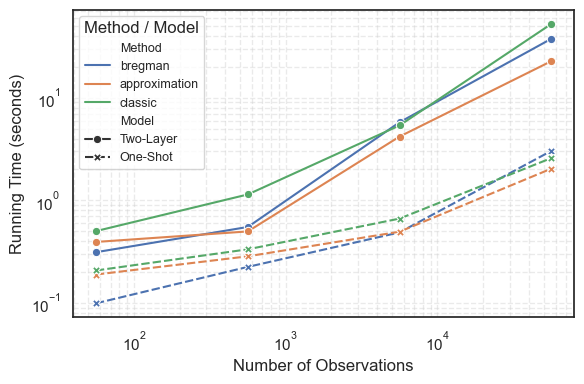

In [51]:
df = experiment_df[experiment_df["Tol"] == 0.01].melt(
    id_vars=["n_Obs", "Method"],
    value_vars=["Running Time TL", "Running Time OS"],
    var_name="Model",
    value_name="Running Time"
)

# Rename method labels
df["Model"] = df["Model"].map({
    "Running Time TL": "Two-Layer",
    "Running Time OS": "One-Shot"
})

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df,
    x="n_Obs",
    y="Running Time",
    hue="Method",
    style="Model",
    markers=True
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
#plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend(title="Method / Model", loc="best", fontsize=9,)
plt.tight_layout()
#plt.savefig("plots/time_dataset.pdf")
plt.show()


## Synthetic data

In [38]:
def sim_data(N):
    val = []
    vm_mu = [0.0, np.pi / 3, np.pi]
    vm_kappa = [3.5, 0.8, 1.0]
    vm_syn = np.empty(shape=(N, 2))
    gauss_syn = np.empty(shape=(N, 2))
    index = 0

    for i, num in enumerate(np.random.multinomial(N, loc_mixture.weights)):
        mean, cov = loc_mixture.components[i].params
        gauss = np.random.multivariate_normal(mean, cov, size=num)
        gauss_syn[index:num + index, :] = gauss
        for j, num_vm in enumerate(np.random.multinomial(num, [0.3, 0.6, 0.1])):
            von_mises_angle = np.random.vonmises(mu=vm_mu[j] + np.random.uniform(0, 1, 1),
                                                 kappa=vm_kappa[j] + np.random.uniform(0, 0.1, 1),
                                                 size=num_vm)
            cos = np.cos(von_mises_angle)
            sin = np.sin(von_mises_angle)
            vm_syn[index:num_vm + index, :] = np.column_stack([cos, sin])
            index += num_vm

    syn_data = np.column_stack([gauss_syn, vm_syn])
    np.random.shuffle(syn_data)
    return syn_data

def experiment(n_obs_array, syn_data, methods = ("bregman", "approximation", "classic")):
    rows = []
    for n_obs in n_obs_array:
        for tol in [1e-2]:
            for method in methods:

                # Two-layer Model
                loc_mixture = sc.MixtureModel(
                    [sc.MultivariateGaussian() for _ in range(K_loc)],
                    init=init,
                    rng=10,
                )
                dir_mixtures = [sc.MixtureModel(
                    [sc.VonMises() for _ in range(K_dir[j])],
                    init=init,
                    rng=j,
                )
                    for j in range(K_loc)]


                model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
                start = time()
                model.fit(syn_data[:n_obs, :2],
                          syn_data[:n_obs, 2:],
                          case=method,
                          tol=1e-2,
                          verbose=False)
                end_tl = round(time() - start, 4)
                bic_score_tl = round(model.bic_score(syn_data[:n_obs, :2],
                                                     syn_data[:n_obs, 2:]), 2)

                # One-shot Model
                model = sc.OneShotScheme(n_clusters=3 * K_loc,
                                         alpha=1,
                                         beta=1,
                                         init=init)

                start = time()
                model.fit(syn_data[:n_obs, :2],
                          syn_data[:n_obs, 2:],
                          case=method,
                          tol=1e-2,
                          verbose=False)
                end_os = round(time() - start, 4)
                bic_score_os = round(model.bic_score(syn_data[:n_obs, :2],
                                                     syn_data[:n_obs, 2:]), 2)

                # Annotate
                row = {
                    "n_Obs": n_obs,
                    "Tol": tol,
                    "Method": method,
                    "BIC Score TL": bic_score_tl,
                    "BIC Score OS": bic_score_os,
                    "Running Time TL": end_tl,
                    "Running Time OS": end_os,
                }
                print(f" {n_obs}, {tol}, {method}, Two-layer: {end_tl}s, One-shot: {end_os}s.")
                rows.append(row)

    return pd.DataFrame(rows)


In [46]:
init = "k-means"
K_loc = 5
K_dir = [3 for _ in range(K_loc)]

N = 10_000_000
syn_data = sim_data(N)
n_obs_array = []
i = 15
while i < N:
    n_obs_array.append(i)
    i = int(i*1.5)

print(n_obs_array)


[15, 22, 33, 49, 73, 109, 163, 244, 366, 549, 823, 1234, 1851, 2776, 4164, 6246, 9369, 14053, 21079, 31618, 47427, 71140, 106710, 160065, 240097, 360145, 540217, 810325, 1215487, 1823230, 2734845, 4102267, 6153400, 9230100]


In [42]:
experiment_syn_df = experiment(n_obs_array, syn_data, methods = ("bregman", "approximation", "classic"))

 15, 0.01, bregman, Two-layer: 0.2185s, One-shot: 0.1262s.
 15, 0.01, approximation, Two-layer: 0.3434s, One-shot: 0.0638s.
 15, 0.01, classic, Two-layer: 0.2095s, One-shot: 0.0979s.
 18, 0.01, bregman, Two-layer: 0.2659s, One-shot: 0.0859s.
 18, 0.01, approximation, Two-layer: 0.1764s, One-shot: 0.0741s.
 18, 0.01, classic, Two-layer: 0.2538s, One-shot: 0.0889s.
 21, 0.01, bregman, Two-layer: 0.1678s, One-shot: 0.0971s.
 21, 0.01, approximation, Two-layer: 0.1667s, One-shot: 0.0749s.
 21, 0.01, classic, Two-layer: 0.2827s, One-shot: 0.1161s.
 25, 0.01, bregman, Two-layer: 0.1919s, One-shot: 0.1393s.
 25, 0.01, approximation, Two-layer: 0.2166s, One-shot: 0.0904s.
 25, 0.01, classic, Two-layer: 0.3312s, One-shot: 0.1774s.
 30, 0.01, bregman, Two-layer: 0.1779s, One-shot: 0.1592s.
 30, 0.01, approximation, Two-layer: 0.2044s, One-shot: 0.07s.
 30, 0.01, classic, Two-layer: 0.2665s, One-shot: 0.1193s.
 36, 0.01, bregman, Two-layer: 0.3048s, One-shot: 0.052s.
 36, 0.01, approximation, Two

In [43]:
experiment_syn_df

,n_Obs,Tol,Method,BIC Score TL,BIC Score OS,Running Time TL,Running Time OS
0,15,0.01,bregman,315.66,-226.60,0.2185,0.1262
1,15,0.01,approximation,315.55,-226.74,0.3434,0.0638
2,15,0.01,classic,315.66,-226.60,0.2095,0.0979
3,18,0.01,bregman,469.72,-112.36,0.2659,0.0859
4,18,0.01,approximation,469.60,-112.48,0.1764,0.0741
...,...,...,...,...,...,...,...
97,7368,0.01,approximation,154514.20,154513.92,3.4463,0.5025
98,7368,0.01,classic,154515.46,154513.99,3.0101,0.6063
99,9003,0.01,bregman,188717.06,188592.28,2.5167,0.5201
100,9003,0.01,approximation,188728.89,188591.94,2.7094,0.4898


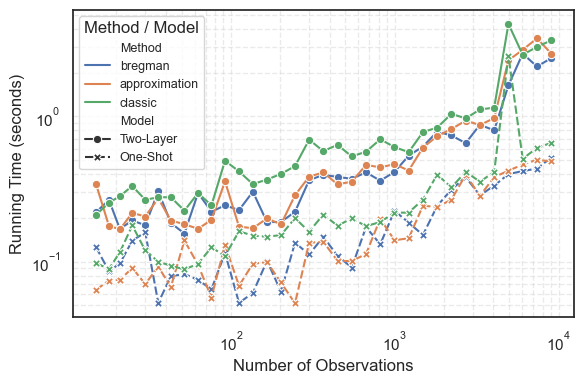

In [52]:
df = experiment_syn_df[experiment_syn_df["Tol"] == 0.01].melt(
    id_vars=["n_Obs", "Method"],
    value_vars=["Running Time TL", "Running Time OS"],
    var_name="Model",
    value_name="Running Time"
)

# Rename method labels
df["Model"] = df["Model"].map({
    "Running Time TL": "Two-Layer",
    "Running Time OS": "One-Shot"
})

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df,
    x="n_Obs",
    y="Running Time",
    hue="Method",
    style="Model",
    markers=True
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Observations")
plt.ylabel("Running Time (seconds)")
#plt.title("Running Time vs. Sample Size by Model")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend(title="Method / Model", loc="best", fontsize=9,)
plt.tight_layout()
#plt.savefig("plots/time_synthetic.pdf")
plt.show()


In [4]:
experiment_syn_df = pd.DataFrame([
[10,0.01,'bregman',5695900,0.0498],
[10,0.01,'approximation',5708919,0.0436],
[10,0.01,'classic',5695902,0.0878],
[20,0.01,'bregman',1958464,0.0398],
[20,0.01,'approximation',1966336,0.0333],
[20,0.01,'classic',1959007,0.0847],
[30,0.01,'bregman',2038446,0.0611],
[30,0.01,'approximation',2046607,0.0635],
[30,0.01,'classic',2038541,0.0925],
[40,0.01,'bregman',1479309,0.0409],
[40,0.01,'approximation',1488666,0.0392],
[40,0.01,'classic',1477694,0.1749],
[50,0.01,'bregman',1331668,0.033],
[50,0.01,'approximation',1346001,0.039],
[50,0.01,'classic',1308244,0.156],
[60,0.01,'bregman',1307976,0.0436],
[60,0.01,'approximation',1315374,0.0429],
[60,0.01,'classic',1296060,0.1551],
[70,0.01,'bregman',1333744,0.0586],
[70,0.01,'approximation',1339081,0.042],
[70,0.01,'classic',1329380,0.2491],
[80,0.01,'bregman',1296215,0.0459],
[80,0.01,'approximation',1300605,0.0469],
[80,0.01,'classic',1296186,0.2257],
[90,0.01,'bregman',1257701,0.0486],
[90,0.01,'approximation',1261076,0.0434],
[90,0.01,'classic',1258041,0.1782],

[100,0.01,'bregman',1266359,0.0376],
[100,0.01,'approximation',1272093,0.0413],
[100,0.01,'classic',1264837,0.2383],
[200,0.01,'bregman',1235335,0.0659],
[200,0.01,'approximation',1238192,0.0544],
[200,0.01,'classic',1234740,0.4028],
[300,0.01,'bregman',1213398,0.0546],
[300,0.01,'approximation',1215274,0.0528],
[300,0.01,'classic',1212900,0.2056],
[400,0.01,'bregman',1214466,0.0772],
[400,0.01,'approximation',1216132,0.0661],
[400,0.01,'classic',1215025,0.2745],
[500,0.01,'bregman',1210376,0.0871],
[500,0.01,'approximation',1212240,0.0555],
[500,0.01,'classic',1210739,0.1955],
[600,0.01,'bregman',1211893,0.0798],
[600,0.01,'approximation',1213801,0.095],
[600,0.01,'classic',1211446,0.3835],
[700,0.01,'bregman',1210786,0.0939],
[700,0.01,'approximation',1212389,0.1108],
[700,0.01,'classic',1211442,0.3196],
[800,0.01,'bregman',1211267,0.0842],
[800,0.01,'approximation',1212360,0.1282],
[800,0.01,'classic',1211372,0.3151],
[900,0.01,'bregman',1209886,0.095],
[900,0.01,'approximation',1211219,0.1689],
[900,0.01,'classic',1209996,0.3066],

[1000,0.01,'bregman',1207635,0.1623],
[1000,0.01,'approximation',1208486,0.1779],
[1000,0.01,'classic',1207637,0.4606],
[2000,0.01,'bregman',1205545,0.1939],
[2000,0.01,'approximation',1206332,0.2318],
[2000,0.01,'classic',1205599,0.5547],
[3000,0.01,'bregman',1209657,0.3367],
[3000,0.01,'approximation',1209726,0.4621],
[3000,0.01,'classic',1209324,1.0496],
[4000,0.01,'bregman',1208001,0.3407],
[4000,0.01,'approximation',1208745,0.508],
[4000,0.01,'classic',1208189,1.0804],
[5000,0.01,'bregman',1208567,0.8581],
[5000,0.01,'approximation',1209930,0.6268],
[5000,0.01,'classic',1208812,2.0078],
[6000,0.01,'bregman',1208287,0.4122],
[6000,0.01,'approximation',1209759,0.5438],
[6000,0.01,'classic',1208213,0.9549],
[7000,0.01,'bregman',1208307,0.7379],
[7000,0.01,'approximation',1209257,1.1448],
[7000,0.01,'classic',1208309,2.4831],
[8000,0.01,'bregman',1208018,0.9448],
[8000,0.01,'approximation',1208518,1.3477],
[8000,0.01,'classic',1208184,3.0564],
[9000,0.01,'bregman',1208834,0.8952],
[9000,0.01,'approximation',1209422,1.096],
[9000,0.01,'classic',1208992,4.2046],

[10000,0.01,'bregman',1203573,2.1886],
[10000,0.01,'approximation',1204724,1.1469],
[10000,0.01,'classic',1203657,5.4932],
[20000,0.01,'bregman',1203814,2.3824],
[20000,0.01,'approximation',1205560,1.6434],
[20000,0.01,'classic',1203962,6.4828],
[30000,0.01,'bregman',1203272,4.5507],
[30000,0.01,'approximation',1204530,3.7891],
[30000,0.01,'classic',1203354,15.7154],
[40000,0.01,'bregman',1202763,4.9348],
[40000,0.01,'approximation',1203202,10.0103],
[40000,0.01,'classic',1202756,24.6309],
[50000,0.01,'bregman',1203384,5.3558],
[50000,0.01,'approximation',1203470,14.4548],
[50000,0.01,'classic',1203421,33.3902],
[60000,0.01,'bregman',1203218,14.3962],
[60000,0.01,'approximation',1203528,11.4878],
[60000,0.01,'classic',1203188,41.4523],
[70000,0.01,'bregman',1203193,14.4923],
[70000,0.01,'approximation',1204555,14.3357],
[70000,0.01,'classic',1203321,52.4047],
[80000,0.01,'bregman',1202901,15.6234],
[80000,0.01,'approximation',1202956,17.9101],
[80000,0.01,'classic',1203039,50.7976],
[90000,0.01,'bregman',1203966,22.4991],
[90000,0.01,'approximation',1204092,23.3311],
[90000,0.01,'classic',1203899,69.2894],

[100000,0.01,'bregman',1211446,12.0846],
[100000,0.01,'approximation',1212454,16.535],
[200000,0.01,'bregman',1211796,68.4655],
[200000,0.01,'approximation',1212168,56.6953],
[300000,0.01,'bregman',1212862,186.7009],
[300000,0.01,'approximation',1213000,98.0085],
[400000,0.01,'bregman',1211979,72.9596],
[400000,0.01,'approximation',1212044,173.0419],
[500000,0.01,'bregman',1212756,120.2853],
[500000,0.01,'approximation',1212580,217.7321],
[600000,0.01,'bregman',1212266,179.4779],
[600000,0.01,'approximation',1211736,281.6361],
[700000,0.01,'bregman',1211642,342.596],
[700000,0.01,'approximation',1211533,282.1071],
[800000,0.01,'bregman',1212296,185.5256],
[800000,0.01,'approximation',1211744,444.4027],
[900000,0.01,'bregman',1212763,118.0705],
[900000,0.01,'approximation',1211951,750.3142],

[1000000,0.01,'bregman',1203146,388.0165],
[1000000,0.01,'approximation',1202605,525.79],

], columns=["n_obs", "tol", "model", "bic_score", "running_time"])


(10000, 4)